# (Self Study) Monitoring results with TensorBoard

Use `torch.utils.tensorboard.SummaryWriter` to log
1. scalars (e.g., train loss, validation loss)
1. histograms (e.g., weight matrices, gradients)
1. images (e.g., decision boundaries, precision/recall curves)

In [1]:
import io

import common
import nn_lib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import tensorflow as tf
import torch
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils.data
import torch.utils.tensorboard

## Data

In [2]:
X, y = nn_lib.generate_data(N=2_000)

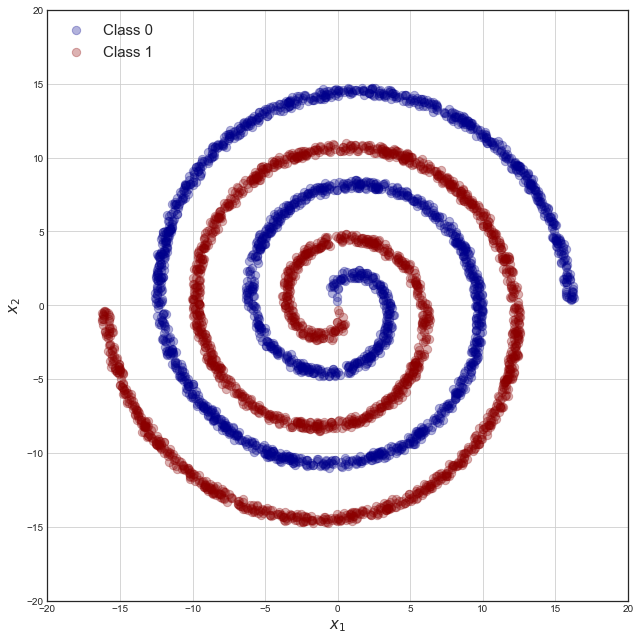

In [3]:
nn_lib.plot_spiral(X, y, xlim=(-20, 20), ylim=(-20, 20))

In [4]:
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    X, y, test_size=0.20, random_state=501
)

## Add TensorBoard logging to `torch` model

### Seeds for reproducibility

In [5]:
torch.manual_seed(501)
np.random.seed(501)

### Config

In [6]:
config = {
    "trainer": {
        "epochs": 600,
    },
    "model": {
        "n_features": 2,
        "layers": [20, 15, 10, 5],
    },
    "data": {
        "train": {
            "batch_size": 512,
            "shuffle": True,
            "drop_last": True,
        },
        "valid": {
            "batch_size": x_valid.shape[0],
            "shuffle": False,
            "drop_last": False,
        },
    },
    "optimizer": {
        "lr": 0.01,
    },
}

### Data

In [7]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

In [8]:
ds_train = torch.utils.data.TensorDataset(x_train, y_train)
dl_train = torch.utils.data.DataLoader(ds_train, **config["data"]["train"])

In [9]:
xx = np.linspace(-20, 20, 400)
yy = np.linspace(-20, 20, 400)
gx, gy = np.meshgrid(xx, yy)

### Trainer

During and after training, run TensorBoard with 
```
tensorboard --logdir=runs_01
```

Open TensorBaord at http://localhost:6006/.

Plot decision boundary with helper function `plot_to_image`.

In [10]:
def plot_to_image(x, y, z):
    fig = plt.figure()
    plt.contourf(x, y, z, cmap=plt.cm.coolwarm, alpha=0.7)
    plt.axis("off")
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format="png", dpi=75)
    plt.close()
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=3)
    cm_image = np.swapaxes(np.swapaxes(image * 2, 0, 2), 1, 2)
    return cm_image

In [11]:
writer = torch.utils.tensorboard.SummaryWriter("runs_01/test_00")

model = nn_lib.Net(**config["model"])
opt = torch.optim.Adam(model.parameters(), **config["optimizer"])

for epoch in range(config["trainer"]["epochs"]):

    model.train()
    for xb, yb in dl_train:
        opt.zero_grad()
        loss_train = torch.nn.functional.binary_cross_entropy_with_logits(
            model(xb).flatten(), yb
        )
        loss_train.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        loss_valid = torch.nn.functional.binary_cross_entropy_with_logits(
            model(x_valid).flatten(), y_valid
        )

    writer.add_scalar("loss/train", loss_train, epoch)
    writer.add_scalar("loss/valid", loss_valid, epoch)

    for i in range(len(model.hidden)):
        writer.add_histogram(f"weights/h{i}", model.hidden[i].weight.flatten(), epoch)
        writer.add_histogram(f"weights/b{i}", model.hidden[i].bias, epoch)

    for i in range(len(model.hidden)):
        writer.add_histogram(f"grad/h{i}", model.hidden[i].weight.grad.flatten(), epoch)
        writer.add_histogram(f"grad/b{i}", model.hidden[i].bias.grad, epoch)

    if epoch % 20 == 0:
        Z = (
            model(torch.tensor(np.c_[gx.ravel(), gy.ravel()].astype(np.float32)))
            .detach()
            .numpy()
            .reshape(gx.shape)
        )
        writer.add_image("test", plot_to_image(gx, gy, Z), epoch)

writer.flush()
writer.close()

<br>
<br>
&mdash; <br>
Sebastian Gabel <br>
`Learning from Big Data`, Module 3, Lecture 11 <br>
2021/22 <br>